In [9]:
from IPython.display import display

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
import sys

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sys.path.insert(1,'../')

In [2]:
from data.dataset import ShopDataset
from model.forecaster import Forecaster

In [3]:
df = pd.read_csv("../data/sales-info.csv.gz")

In [11]:
df.head()

,documentDate,DocumnetNumber,ItemCode,PaymentTerm,Quantity,Region
0,2015-01-01,INV017109010,PF0084103,30 Days,4,Region 5
1,2015-01-01,INV017109010,TT0010103,30 Days,5,Region 5
2,2015-01-01,INV017109010,WF8060101,30 Days,12,Region 5
3,2015-01-01,INV024111613,GF4501101,30 Days,60,Region 3
4,2015-01-01,INV015810027,GF4501101,Cash,12,Region 10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195773 entries, 0 to 1195772
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   documentDate    1195773 non-null  object
 1   DocumnetNumber  1195773 non-null  object
 2   ItemCode        1195773 non-null  object
 3   PaymentTerm     1160747 non-null  object
 4   Quantity        1195773 non-null  int64 
 5   Region          1122485 non-null  object
dtypes: int64(1), object(5)
memory usage: 54.7+ MB


In [6]:
df.describe()

,Quantity
count,1.195773e+06
mean,4.721201e+01
std,4.038206e+02
min,0.000000e+00
25%,6.000000e+00
50%,1.200000e+01
75%,3.000000e+01
max,1.000000e+05


In [7]:
datetime_info = pd.to_datetime(df['documentDate']).describe().to_dict()

In [8]:
datetime_info

{'count': 1195773,
 'unique': 361,
 'top': Timestamp('2015-11-30 00:00:00'),
 'freq': 6353,
 'first': Timestamp('2015-01-01 00:00:00'),
 'last': Timestamp('2015-12-31 00:00:00')}

In [12]:
unique_counts = df.nunique().to_dict()

In [13]:
unique_counts

{'documentDate': 361,
 'DocumnetNumber': 651748,
 'ItemCode': 37,
 'PaymentTerm': 17,
 'Quantity': 1117,
 'Region': 12}

In [14]:
df.isna().sum()

documentDate          0
DocumnetNumber        0
ItemCode              0
PaymentTerm       35026
Quantity              0
Region            73288
dtype: int64

## Little-bit about dataset.
 - This is shop sales dataset in year 2015. Includes both invoice and return records. First two letters of the item code represent the item category.

In [15]:
f"There are {len(df):,} records in dataset from {datetime_info['first']} to {datetime_info['last']}. There are {unique_counts['ItemCode']} unique item available"

'There are 1,195,773 records in dataset from 2015-01-01 00:00:00 to 2015-12-31 00:00:00. There are 37 unique item available'

 - `GOAL`: Build a demand forecasting model for each region-product pair in the dataset
 - Let's remove all records with `null` region info

In [16]:
df.dropna(subset=['Region'],inplace=True)

In [17]:
df.shape

(1122485, 6)

create `product_category` column

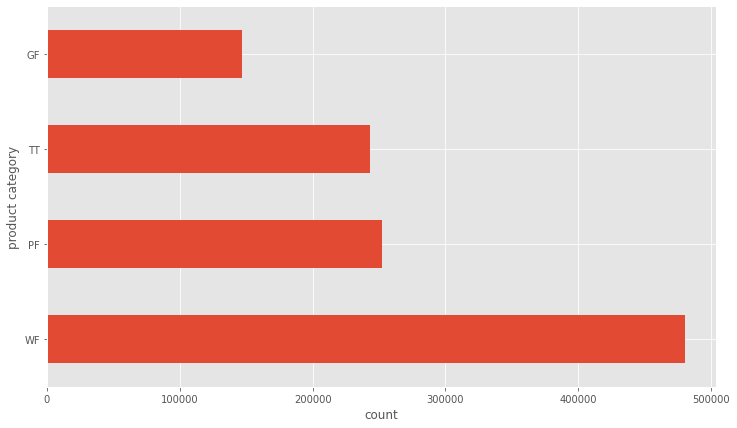

In [18]:
df['productCategory'] = df['ItemCode'].apply(lambda x:x[:2])

df['productCategory'].value_counts().plot.barh(figsize=(12,7))
plt.xlabel("count")
plt.ylabel("product category")
plt.show()

Let's build `ShopDataset`
 - ShopDataset - This will build seperate datset for each region-product pair, This includes the outlier removal as well

In [19]:
?ShopDataset

Init signature: ShopDataset(data, region_column, product_col, date_column, target_col) -> None
Docstring:      The dataset class
Init docstring:
data: pandas dataframe including all information of invoice sales/return 
region_column: this is the column name related to the regions in the dataset
product_col: this is the column name related to the product categpry in the dataset
date_column: time stamp column in the dataset
target_col: the column name, that we are going to forecast
File:           ~/store-sales-prediction/data/dataset.py
Type:           type
Subclasses:     


In [20]:
dataset = ShopDataset(
    data=df,
    region_column='Region',
    product_col='productCategory',
    date_column='documentDate',
    target_col='Quantity'
    )

Let's call `define_regional_datasets` method. Under the hood this will use `pd.pivot_table` to create seperate datasets for each `region-product` pair

In [21]:
dataset.define_regional_datasets()

100%|██████████| 12/12 [00:01<00:00, 10.02it/s]


In [22]:
#ex.
dataset.region_10_data.head()

productCategory,GF,PF,TT,WF
documentDate,,,,
2015-01-01,72.0,512.0,0.0,314.0
2015-01-02,30.0,1659.0,0.0,87.0
2015-01-03,66.0,1052.0,0.0,539.0
2015-01-04,0.0,51.0,0.0,100.0
2015-01-05,0.0,2092.0,0.0,0.0


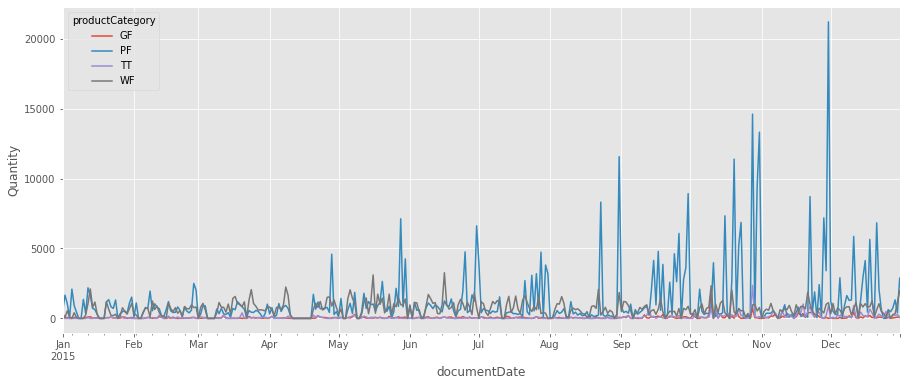

In [23]:
dataset.region_10_data.plot(figsize=(15,6))
plt.ylabel("Quantity")
plt.show()

Since each product have diferent demand plet's plot each product induvudually 

In [24]:
def plot_regional_dataset(data):
    df = deepcopy(data)
  
    _,ax = plt.subplots(nrows=df.shape[1],figsize=(15,8*df.shape[1]))

    for i,product in enumerate(df.columns):
        df[product].plot(ax=ax[i],color='#f25f0a')
        ax[i].set_title(f"{product} sales in given region",fontweight='semibold')
        ax[i].set_ylabel("demand")
    plt.show()

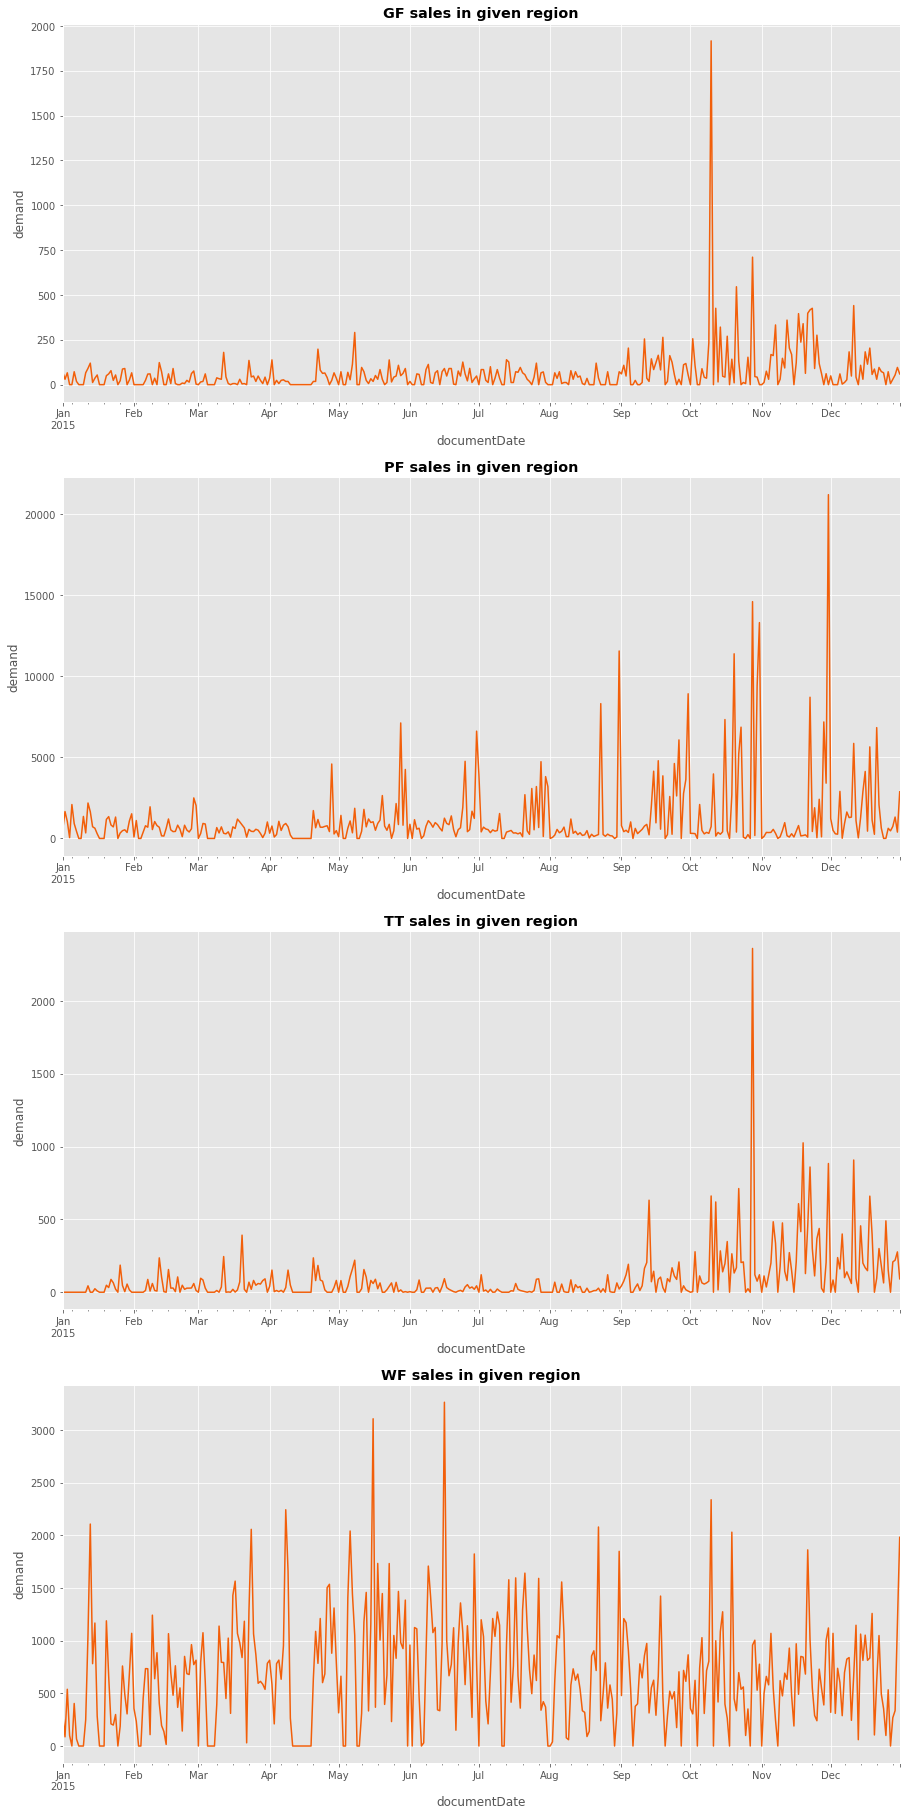

In [25]:
plot_regional_dataset(dataset.region_10_data)

In [26]:
def plot_product_contribution(dataset):
    df = deepcopy(dataset)

    _,ax = plt.subplots(3,4,figsize=(15,2*8))
    axi = ax.flatten()

    regional_datasets = (getattr(dataset,f"region_{i+1}_data") for i in range(len(dataset.regions)) )
    for i,region_df in enumerate(regional_datasets):
        region_pct = region_df.sum()
        axi[i].pie(region_pct,labels=region_pct.index,autopct='%.2f')
        axi[i].set_title(f"Region {i+1}")

    plt.suptitle(f"Product sales distribution in each region".upper(),fontweight='bold',)
    plt.tight_layout()
    plt.show()

## How each product distributed accros each region?

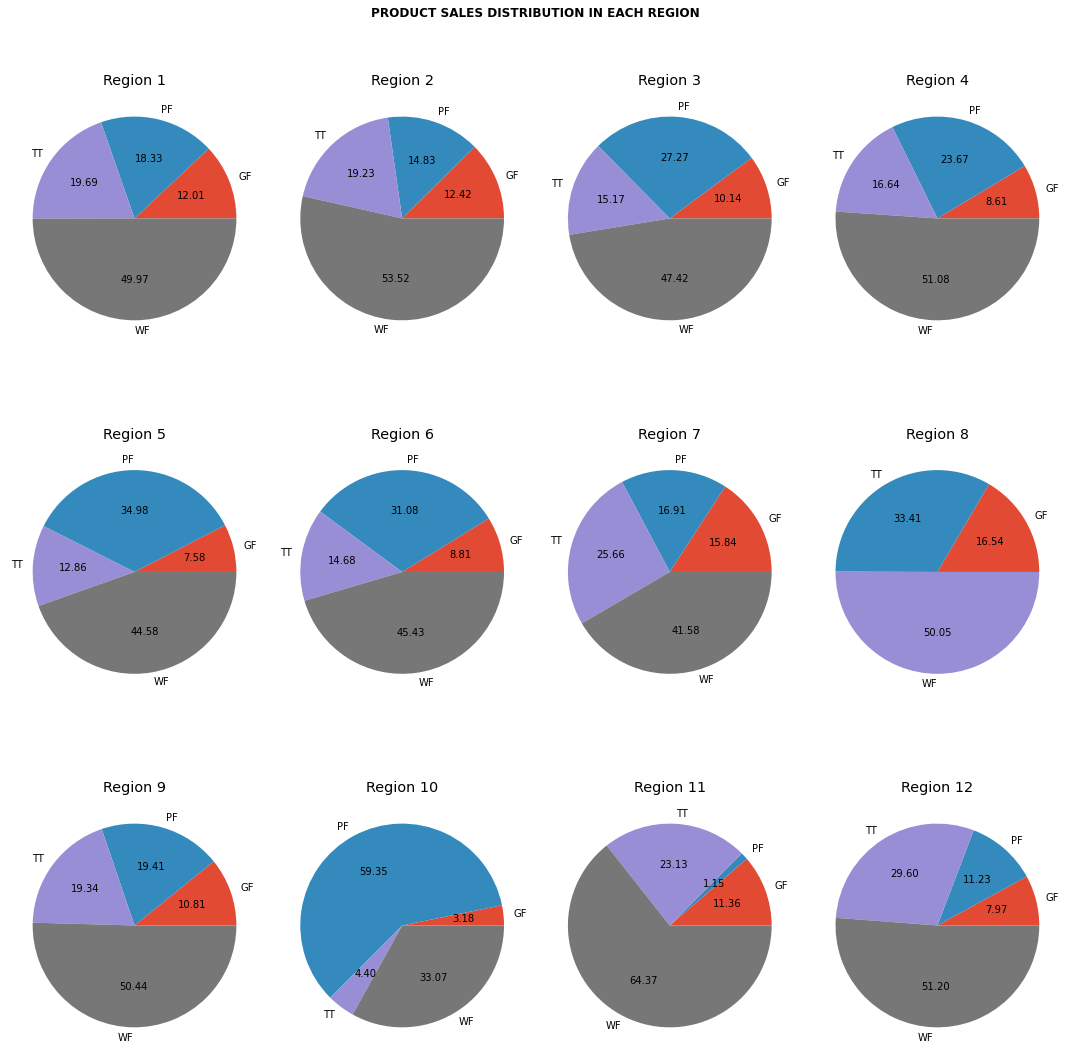

In [27]:
plot_product_contribution(dataset)

## How each region contibuted to sales?

In [52]:
def plot_region_contribution(dataset):
    df = deepcopy(dataset)
    
    region_map = map(lambda x:x.replace(" ","_").lower(),dataset.regions)
    region_revenue_map = {}
    for i,region in enumerate(region_map):
        regional_dataset = getattr(dataset,f"{region}_data")
        region_pct = regional_dataset.sum().sum()
        region_revenue_map[region] = region_pct

    plt.figure(figsize=(8,8))
    plt.pie(region_revenue_map.values(),labels=region_revenue_map.keys(),autopct='%.2f')
    plt.title(f"Region contibution to sales".upper(),fontweight='bold')

    plt.tight_layout()
    plt.show()

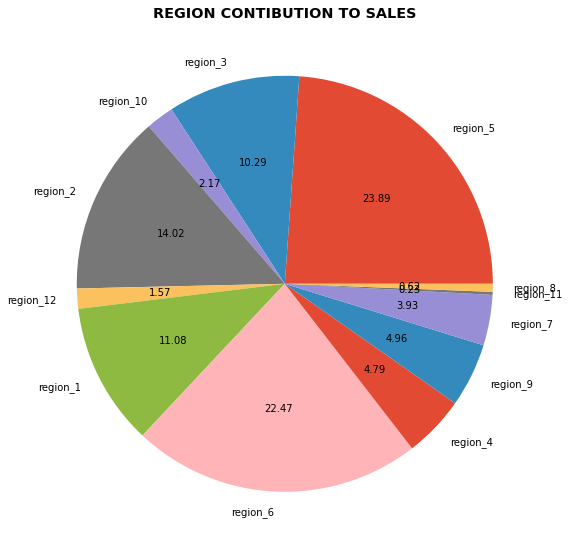

In [53]:
plot_region_contribution(dataset)

## Region seles count behaviour by weekday, month

In [69]:
df['dayName'] = pd.to_datetime(df['documentDate']).dt.day_name()
df['Month'] = pd.to_datetime(df['documentDate']).dt.month_name()

In [75]:
month_vs_region_sales = pd.pivot_table(data=df,index='Month',columns='Region',values='Quantity',aggfunc=sum)
day_vs_region_sales = pd.pivot_table(data=df,index='dayName',columns='Region',values='Quantity',aggfunc=sum)

In [78]:
sns.set_style('whitegrid')

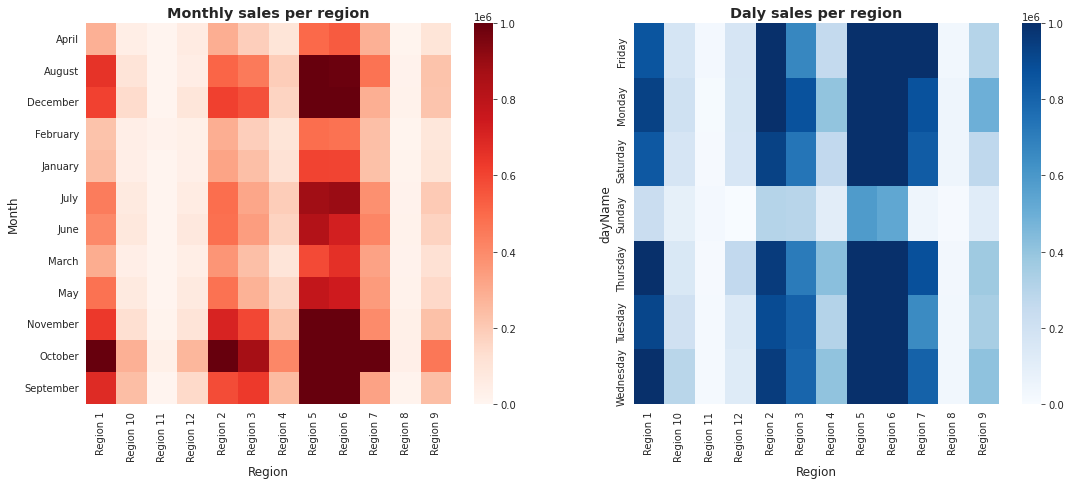

In [108]:
_,ax = plt.subplots(1,2,figsize=(18,7))

sns.heatmap(month_vs_region_sales,cmap='Reds',vmin=0,vmax=1e6,ax=ax[0])
sns.heatmap(day_vs_region_sales,cmap='Blues',vmin=0,vmax=1e6,ax=ax[1])

ax[0].set_title("Monthly sales per region",fontweight='bold')
ax[1].set_title("Daly sales per region",fontweight='bold')
plt.show()

### Key insights
 - `Region 11 & Region 8` shows lower performance compaire to the other regions
 - For most regions, `Sunday` seems to be off day
 - There are very low sales for `February to January`
 - `Regions 6 & 5` and `Regions 1 & 2` show identical behaviour

## Modeling

In [123]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [173]:
forecaster = Forecaster(dataset=dataset,holidays=None,test_size=0.1)
forecaster.fit(include_history=False)

  0%|          | 0/12 [00:00<?, ?it/s]17:56:25 - cmdstanpy - INFO - Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:27 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:02<00:28,  2.56s/it]17:56:27 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

In [174]:
def plot_predictions(forecaster,region,cat):
    forecaster = deepcopy(forecaster)
    forecast = forecaster.results[region][cat]['forecast']
    error = forecaster.results[region][cat]['error']
    test = forecaster.results[region][cat]['test']
    test.set_index("ds",inplace=True)
    yhat_lower = forecast['yhat_lower']
    yhat_upper = forecast['yhat_upper']
    yhat = forecast['yhat']
    ds = forecast['ds']

    plt.figure(figsize=(15,7))
    plt.plot(ds,yhat,label='predictions')
    plt.fill_between(x=ds,y1=yhat_lower,y2=yhat_upper,color='gray', alpha=0.2)
    plt.plot(test['y'],label='True')
    plt.xticks(pd.date_range(min(ds),max(ds),periods=10))
    plt.legend(loc='upper right')
    plt.text(x=ds[0],y=max(yhat_upper),s=f"Mean Absulte Error: {error:.1f}",backgroundcolor='y')
    plt.title(f"Predictions vs. real data ({region}:{cat})".upper(),fontweight='semibold')
    plt.show()

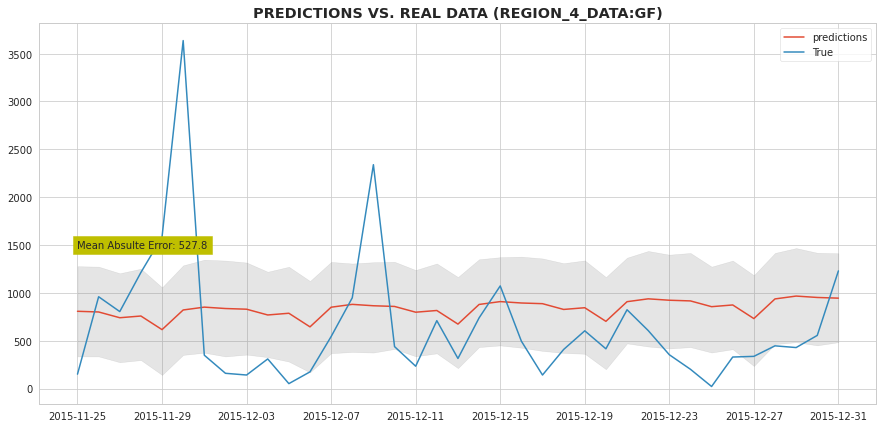

In [177]:
plot_predictions(forecaster,'region_4_data','GF')

## Adding holiday infomation

In [178]:
from datetime import date, timedelta

def all_sundays(year):
    dt = date(year, 1, 1)     
    dt += timedelta(days = 6 - dt.weekday())  
    while dt.year == year:
        yield dt
        dt += timedelta(days = 7)

In [179]:
sundays = []
_ = [sundays.extend(list(all_sundays(year))) for year in [2015,2016,2017,2018,2019,2020]]

sundays = pd.DataFrame({
  'holiday': 'sunday',
  'ds': pd.to_datetime(sundays),
  'lower_window': 0,
  'upper_window': 1,
})

In [180]:
forecaster = Forecaster(dataset=dataset,holidays=sundays,test_size=0.1)
forecaster.fit(include_history=False)

  0%|          | 0/12 [00:00<?, ?it/s]18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:03<00:38,  3.47s/it]18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

- Testing model

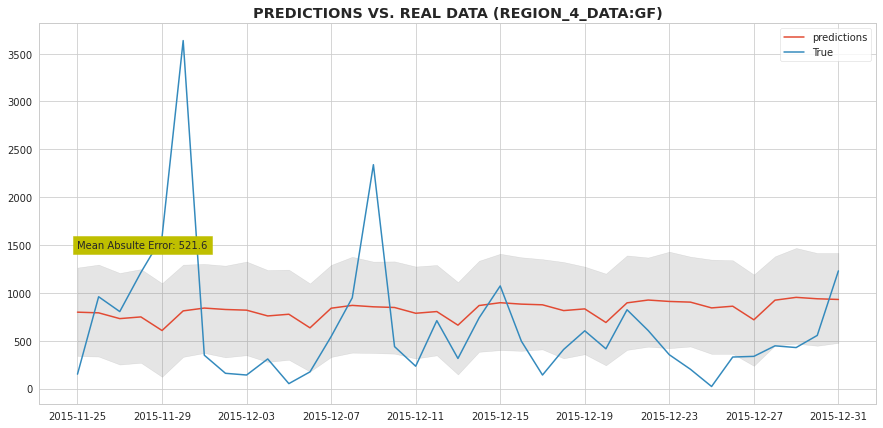

In [181]:
plot_predictions(forecaster,'region_4_data','GF')

In [184]:
forecaster = Forecaster(dataset=dataset,holidays=sundays,test_size=0.1)
forecaster.fit(include_history=False,add_country_holidays='AT',weekly_seasonality=True,yearly_seasonality=False)

AssertionError: 